In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import display, HTML
import numpy as np
import os
import json
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, leaves_list

In [11]:
def initialize_notebook():
    # Display settings for the Jupyter notebook
    display(HTML("<style>:root { --jp-notebook-max-width: 95% !important; }</style>"))
    # Add the font to the font manager
    #fm.fontManager.addfont('/projects/p30802/Cydney/Arial.ttf')
    # Set the font globally
    #plt.rc('font', family='Arial')
    # Set default figure size and DPI
    plt.rcParams['figure.figsize'] = (1.7, 1.6)
    plt.rcParams['figure.dpi'] = 400
    # Set default grid settings
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.color'] = '0.8'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = 0.3
    plt.rcParams['grid.alpha'] = 0.3
    # Set default tick parameters
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['xtick.major.width'] = 0.25
    plt.rcParams['ytick.major.width'] = 0.25
    plt.rcParams['xtick.major.size'] = 2  # This is the length
    plt.rcParams['ytick.major.size'] = 2  # This is the length
    plt.rcParams['xtick.major.pad'] = 2
    plt.rcParams['ytick.major.pad'] = 2
    # Set default spine width
    plt.rcParams['axes.linewidth'] = 0.25
    # Set default labels and title size
    plt.rcParams['axes.labelsize'] = 6
    plt.rcParams['axes.titlesize'] = 7
    plt.rcParams['axes.labelpad'] = 0.5
    # Set default legend settings
    plt.rcParams['legend.fontsize'] = 5
    plt.rcParams['legend.title_fontsize'] = 6
    # Automatically apply the function to remove spines whenever a figure is created
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False

initialize_notebook()

In [ ]:
def cluster_features(df, non_na_features, threshold = 3):
    """
        Clusters features based on a correlation matrix defining how correlated each feature is to one another
        The goal is to select parsimonious feature sets 
    """
    #Calculate correlation matrix for numeric features
    X = df[non_na_features]
    corr_matrix = X.corr() # Absolute correlation
    corr_matrix = corr_matrix.fillna(0) 


    # Compute hierarchical clustering on distance matrix
    distance_matrix = 1 - corr_matrix.abs()  # High correlation → Low distance
    linkage = hierarchy.linkage(distance_matrix, method='average')
    cluster_order = leaves_list(linkage)
    plot_dendrogram(linkage, threshold)

    # Reorder the correlation matrix
    clustered_corr = corr_matrix.iloc[cluster_order, cluster_order]
    #plot_corr_matrix(clustered_corr)

    # Cut the dendrogram to form clusters
    cluster_ids = hierarchy.fcluster(linkage, threshold, criterion='distance')

    # Map each feature to its cluster
    cluster_map = pd.DataFrame({'Feature': X.columns, 'Cluster': cluster_ids})
    cluster_map.sort_values('Cluster')

    return clustered_corr, linkage, cluster_map

def plot_corr_matrix(clustered_corr):
    # Plot heatmap of absolute correlations between features
    plt.figure(figsize=(5, 5))
    sns.heatmap(clustered_corr.abs(), cmap="RdBu", center=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_dendrogram(linkage, threshold):
    #Plot Dendrogram
    plt.figure(figsize=(5.5, 3))
    hierarchy.dendrogram(linkage,color_threshold=threshold)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.gca().set_facecolor('white')
    plt.gcf().patch.set_facecolor('white')

    plt.xticks([])
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.tick_params(axis='y', labelsize=5)
    plt.ylabel('Distance', fontsize=6)
    plt.xlabel('Protein Features', fontsize = 6)
    plt.tight_layout()

    initialize_notebook()
    
def top_features(cluster_map, df):
    """
        Given the clustered features, selects the feature from each cluster most correlated with each target variable 
    """
    cluster_map["corr_log2_fc_75"] = [np.abs(df[["log2_fold_change_75_clip",f]].corr().values[0][1]) for f in cluster_map["Feature"] ]
    cluster_map["corr_log2_fc_4"] = [np.abs(df[["log2_fold_change_4_clip",f]].corr().values[0][1]) for f in cluster_map["Feature"] ]
    cluster_map["corr_log2_fc_50"] = [np.abs(df[["log2_fold_change_50_clip",f]].corr().values[0][1]) for f in cluster_map["Feature"] ]

    # Get top feature per cluster cluster, dropping any NaNs, for each stress

    #75
    idx = cluster_map.groupby('Cluster')['corr_log2_fc_75'].idxmax()
    idx = idx.dropna()  # drop clusters where all values were NaN
    parsimonious_features_75 = cluster_map.loc[idx, ['Feature', 'Cluster', 'corr_log2_fc_75']]["Feature"].values

    #50
    idx = cluster_map.groupby('Cluster')['corr_log2_fc_4'].idxmax()
    idx = idx.dropna()  # drop clusters where all values were NaN
    parsimonious_features_50 = cluster_map.loc[idx, ['Feature', 'Cluster', 'corr_log2_fc_4']]["Feature"].values

    #pH 4
    idx = cluster_map.groupby('Cluster')['corr_log2_fc_50'].idxmax()
    idx = idx.dropna()  # drop clusters where all values were NaN
    parsimonious_features_4 = cluster_map.loc[idx, ['Feature', 'Cluster', 'corr_log2_fc_50']]["Feature"].values

    return parsimonious_features_75, parsimonious_features_50, parsimonious_features_4




In [ ]:
#Datasets from the publication Global Analysis of Aggregation Determinants in Small Protein Domains can be downloaded from Zenodo : https://doi.org/10.5281/zenodo.17477631
df_meta_rg_filter_feature_splits = pd.read_csv("/Users/cydneymartell/Desktop/Datasets_for_publishing_v2/ML_Dataset_Metagenomic_InterpretableFeatures_Cluster_Splits.csv")
meta_test = df_meta_rg_filter_feature_splits.query(""" split == "test" """)
meta_train = df_meta_rg_filter_feature_splits.query(""" split == "train"  """)
meta_valid = df_meta_rg_filter_feature_splits.query(""" split == "valid"  """)
meta_valid_train = df_meta_rg_filter_feature_splits.query(""" split == "train" or split == "valid"  """)

with open("/Users/cydneymartell/Documents/AggregationAnalysis/Interpretable_Machine_Learning/single_value_columns_meta.txt") as file:
    numerical_features = [line.strip() for line in file]
non_na_features= [col for col in numerical_features if df_meta_rg_filter_feature_splits[col].notna().all()]
non_na_features =[i for i in non_na_features if i != "deltaG"] #remove deltaG because  just want to keep deltaG clipped to dynamic range
print(len(non_na_features), len(numerical_features))


1661 2062


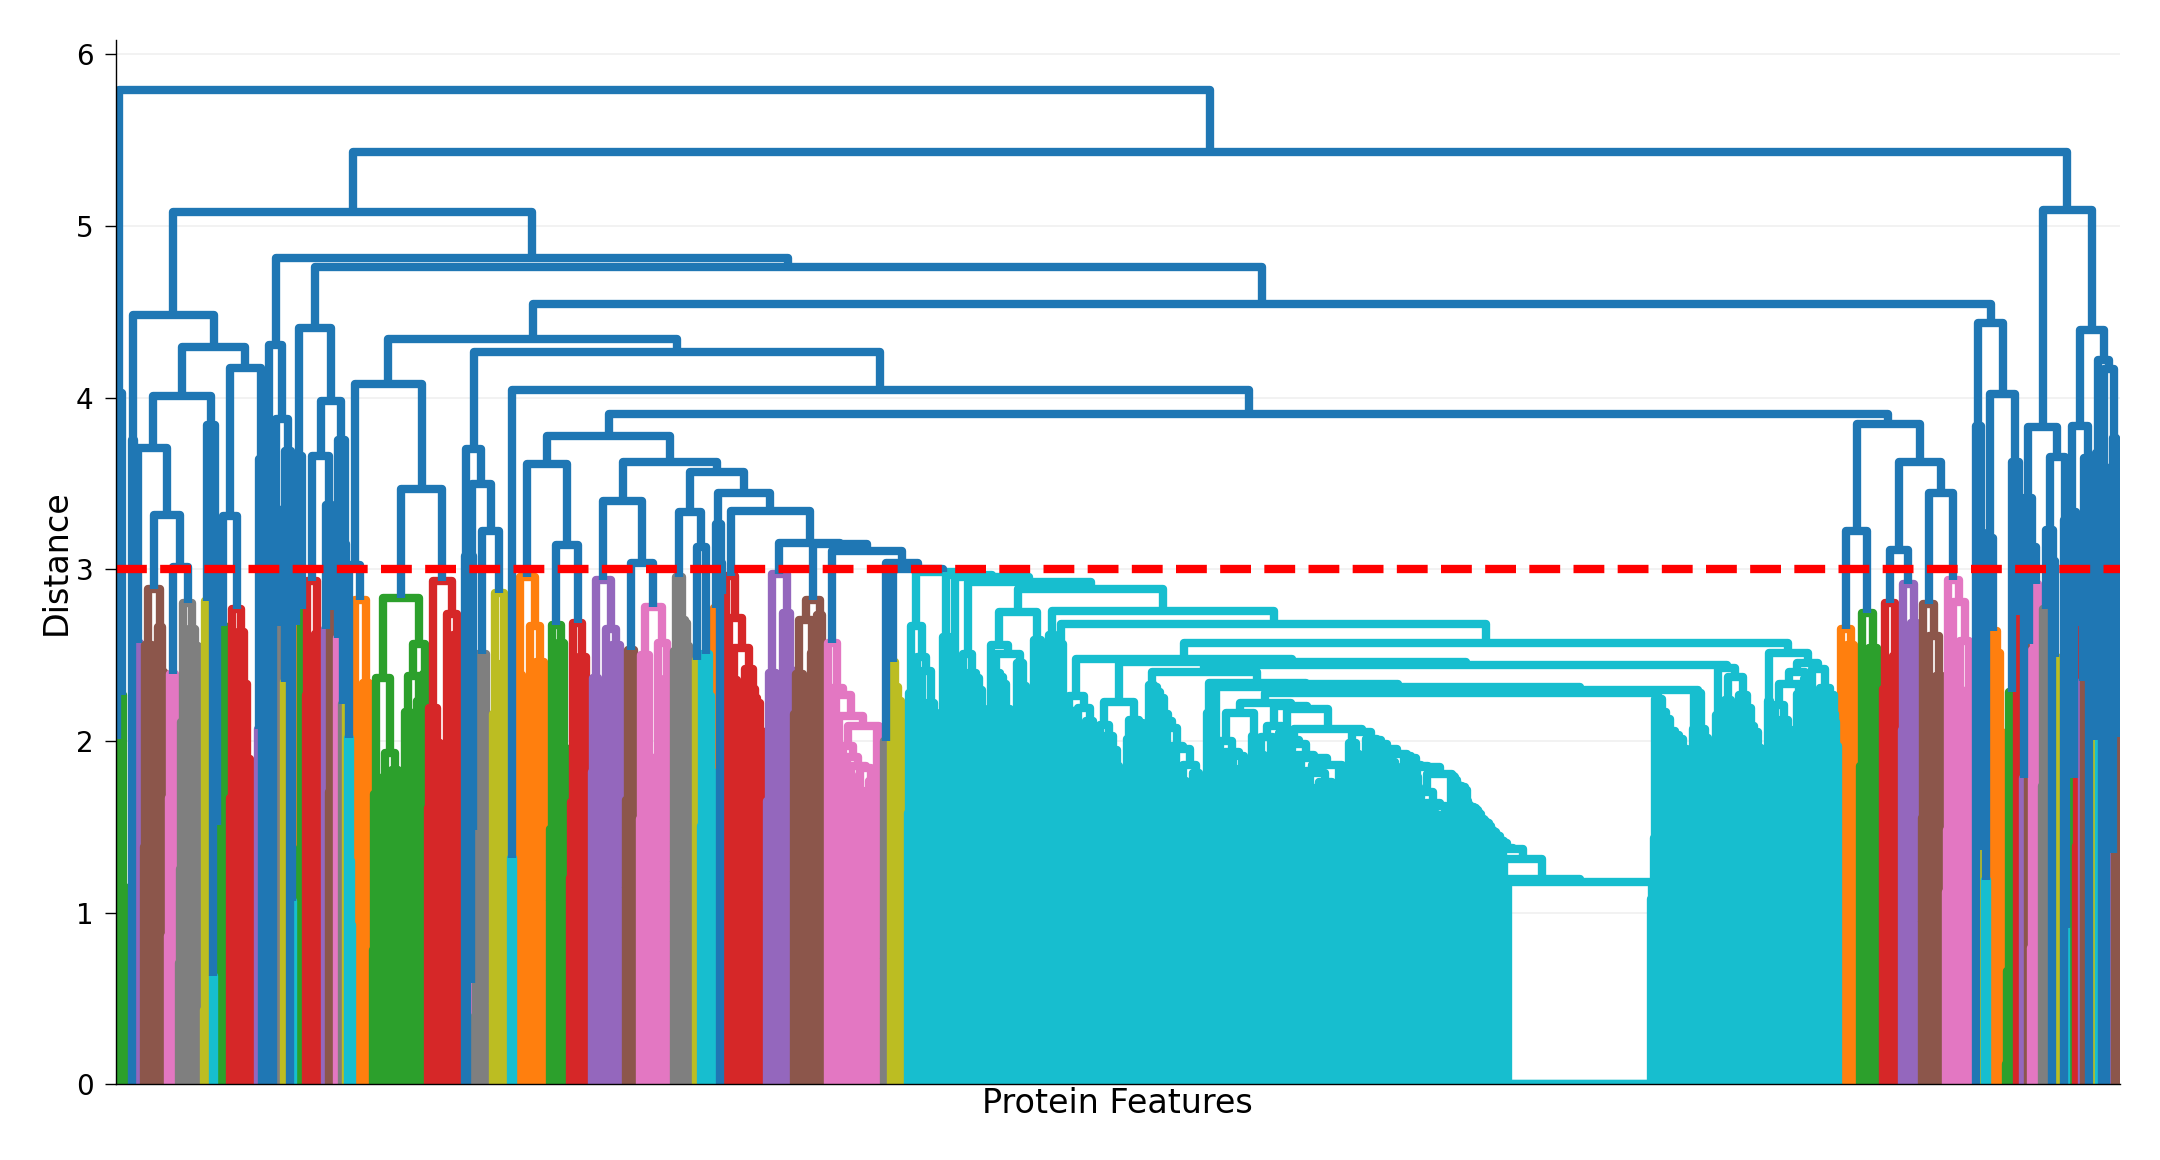

In [24]:
#Cluster features based on threshold
threshold = 3
clustered_corr, linkage, cluster_map= cluster_features(meta_valid_train, non_na_features, threshold)


In [ ]:
#Select and save the top feature from each cluster and save the feature names to json files 
parsimonious_features_75, parsimonious_features_50, parsimonious_features_4 = top_features(cluster_map, meta_valid_train)

data_to_save = {
    "parsimonious_features_75": parsimonious_features_75.tolist() if hasattr(parsimonious_features_75, "tolist") else parsimonious_features_75,
    "parsimonious_features_50": parsimonious_features_50.tolist() if hasattr(parsimonious_features_50, "tolist") else parsimonious_features_50,
    "parsimonious_features_4": parsimonious_features_4.tolist() if hasattr(parsimonious_features_4, "tolist") else parsimonious_features_4,
}

with open(f"cydneymartell/Desktop/parsimonious_features_threshold_{threshold}.json", "w") as f:
    json.dump(data_to_save, f, indent=2)

print(f"Saved lists to parsimonious_features_{threshold}.json")

Saved lists to parsimonious_features_3.json
